<a href="https://colab.research.google.com/github/lhyochan7/MRI-analysis/blob/main/MRI_pix2pix_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install patchify

import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from patchify import patchify, unpatchify
from matplotlib import pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
import time
import glob
import numpy as np
from numpy import savez_compressed
from numpy import load

import gc
gc.collect()
torch.cuda.empty_cache()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing


ADNI_002_S_0685
False
False
ADNI_002_S_1070
False
False
ADNI_002_S_0729
False
False
ADNI_002_S_1261
False
False
 
False
 
False
 
False
 
False


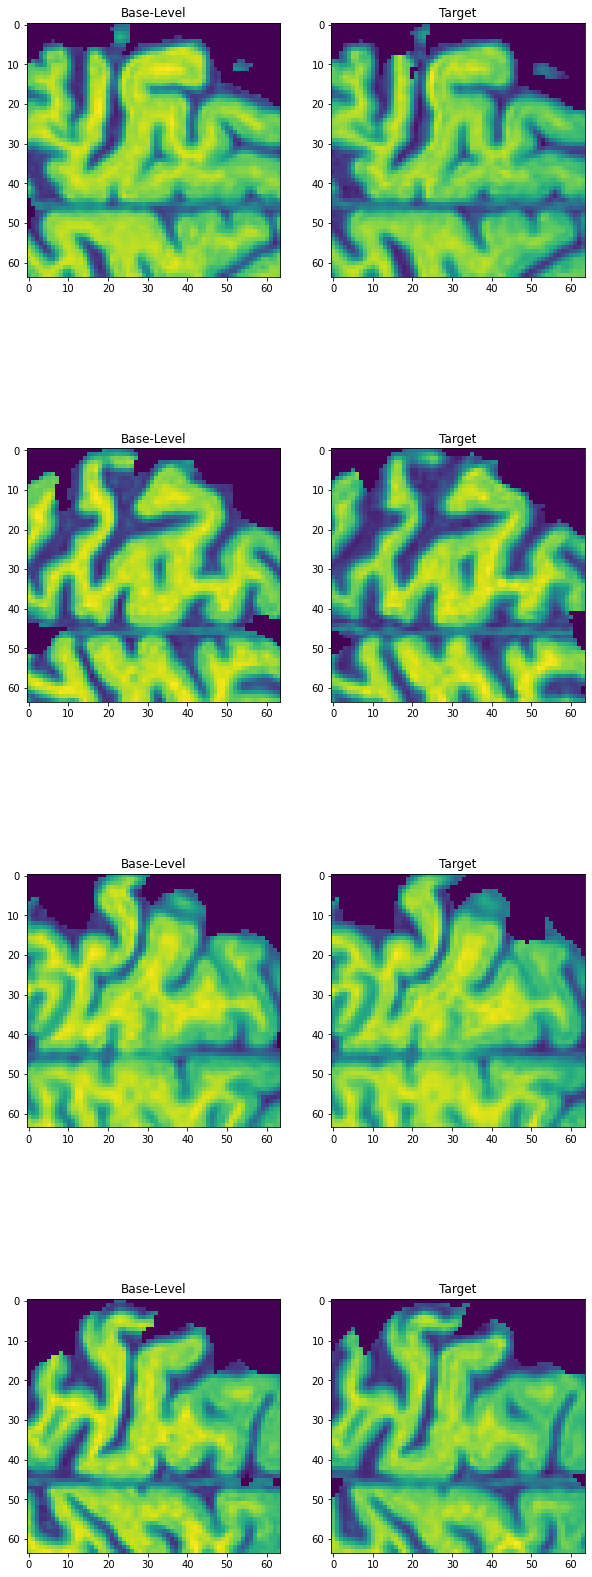

In [4]:
class DataLoader():

  def __init__(self, o_path, t_path):

    self.o_dataset = []
    self.t_dataset = []
    self.org_list = []
    self.tar_list = []
    self.o_path = o_path
    self.t_path = t_path
    self.filename = 'dataset.npz'
    self.d = ['ADNI_002_S_0685', 'ADNI_002_S_1070', 'ADNI_002_S_0729','ADNI_002_S_1261']

  def preprocess(self):
    
    fig = plt.figure(figsize=(10,30))

    for org_file in glob.glob(self.o_path):
      org_base = os.path.basename(org_file)
      org_base = org_base[0:15]
      for tar_file in glob.glob(self.t_path):
          tar_base = os.path.basename(tar_file)
          tar_base = tar_base[0:15]

          
          #if tar_base == org_base:
          if org_base in self.d and org_base == tar_base:
            org_img = nib.load(org_file)
            tar_img = nib.load(tar_file)

            # convert nii file to numpy array
            data1 = org_img.get_fdata()
            data2 = tar_img.get_fdata()

            print(org_base)
            print(np.isnan(data1).any()) 
            print(np.isnan(data2).any()) 


            self.org_list.append(data1)
            self.tar_list.append(data2)

    num = 1

    # patchify and convert to tensor
    for o_data in self.org_list:
      src_patches = patchify(o_data, (64,64,64), step = 32)

      print(' ')
      print(np.isnan(src_patches).any()) 

      
      #print("Number of Patches = ",len(src_patches))
      #print("Shape of patch = ", src_patches.shape)
      
      ax1 = fig.add_subplot(len(self.org_list),2,num)
      ax1.set_title('Base-Level')
      ax1.imshow(src_patches[1,2,3,:,:,40])
      num += 2
      
      # combine vectors 4 x 5 x 4 to 80 patches
      input_img = np.reshape(src_patches, (-1, 1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5])) # n_patches, x, y, z
      input_img = torch.from_numpy(input_img)
      self.o_dataset.append(input_img)

    num = 2

    # patchify and convert to tensor
    for t_data in self.tar_list:
      target_patches = patchify(t_data, (64,64,64), step = 32)  
    
      ax2 = fig.add_subplot(len(self.tar_list),2,num)
      ax2.set_title('Target')
      ax2.imshow(target_patches[1,2,3,:,:,40])
      num += 2
      
      
      # combine vectors 4 x 5 x 4 to 80 patches
      input_img = np.reshape(src_patches, (-1, 1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5])) # n_patches, x, y, z
      input_img = torch.from_numpy(input_img)
      self.t_dataset.append(input_img)

    # return original and target dataset
    return self.o_dataset, self.t_dataset


  def compress(self, a, b):
    return [a,b]
    #savez_compressed(self.filename, a, b)


  # load and prepare training images
  def load_real_samples(self):
    # load compressed arrays
    data = load(self.filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    return [X1, X2]


# Preprocess MRI images
data = DataLoader('/content/drive/MyDrive/Data/Original/*.gz', '/content/drive/MyDrive/Data/Target/*.gz')
a, b = data.preprocess()



# U-Net


In [5]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv3d(in_channels, out_channels, (4,4,4),stride=(2,2,2),padding=1,bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm3d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)



    def forward(self, x):
        
        x = self.down(x)
        #print("UNetDown:", x.shape)
        return x

'''
# check
x = torch.randn(1,512,4,4,4,device=device)
model = UNetDown(512,512).to(device)
down_out = model(x)
print(down_out.shape)'''

'\n# check\nx = torch.randn(1,512,4,4,4,device=device)\nmodel = UNetDown(512,512).to(device)\ndown_out = model(x)\nprint(down_out.shape)'

In [6]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose3d(in_channels, out_channels,(4,4,4),(2,2,2),padding=1,bias=False),
            nn.InstanceNorm3d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        #print("UNetUp", x.shape)
        return x
'''
# check
x = torch.randn(1, 32,16,16,16, device=device)
model = UNetUp(32, 1).to(device)
out = model(x,down_out)
print(out.shape)'''

'\n# check\nx = torch.randn(1, 32,16,16,16, device=device)\nmodel = UNetUp(32, 1).to(device)\nout = model(x,down_out)\nprint(out.shape)'

# Generator Model


In [7]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,normalize=False,dropout=0.5)      
        #self.down6 = UNetDown(512,512,dropout=0.5)             
        #self.down7 = UNetDown(512,512,dropout=0.5)              
        #self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,256)
        self.up3 = UNetUp(512,128)
        self.up4 = UNetUp(256,64)
        self.up5 = nn.Sequential(
            nn.ConvTranspose3d(128,1,(4,4,4),stride=2,padding=1),
            nn.Tanh()
        )
        
        '''
        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose3d(128,1,1,stride=2,padding=1),
            nn.Tanh()
        )
        '''

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        #d6 = self.down6(d5)
        #d7 = self.down7(d6)
        #d8 = self.down8(d7)


        u1 = self.up1(d5,d4)
        u2 = self.up2(u1,d3)
        u3 = self.up3(u2,d2)
        u4 = self.up4(u3,d1)
        #u5 = self.up(u4,d2)
        #u6 = self.up(u5,d1)
        u5 = self.up5(u4)


        #u1 = self.up1(d8,d7)
        #u2 = self.up2(u1,d6)
        #u3 = self.up3(u2,d5)
        #u4 = self.up4(u3,d4)
        #u5 = self.up5(u4,d3)
        #u6 = self.up6(u5,d2)
        #u7 = self.up7(u6,d1)
        #u8 = self.up8(u7)

        return u5

# check
x = torch.randn(1,1,64,64,64,device=device)
model = GeneratorUNet().to(device)
out = model(x)
print(out.shape)



torch.Size([1, 1, 64, 64, 64])


# Discriminator Model


In [8]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv3d(in_channels, out_channels, (3,3,3), (2,2,2), padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm3d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        #print(x.shape)
        return x

# check
x = torch.randn(1,1,64,64,64,device=device)
model = Dis_block(1,64).to(device)
out = model(x)
print(out.shape)

torch.Size([1, 64, 32, 32, 32])


In [9]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv3d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x

# check
x = torch.randn(1,1,64,64,64,device=device)
model = Discriminator().to(device)
out = model(x,x)
print(out.shape)

torch.Size([1, 1, 4, 4, 4])


# Initalize Weights of Model


In [10]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

In [11]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [12]:
model_gen.train()
model_dis.train()

Discriminator(
  (stage_1): Dis_block(
    (block): Sequential(
      (0): Conv3d(2, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_2): Dis_block(
    (block): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_3): Dis_block(
    (block): Sequential(
      (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_4): Dis_block(
    (block): Sequential(
      (0): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

# Load Dataset

ADNI_002_S_0685
False
False
ADNI_002_S_1070
False
False
ADNI_002_S_0729
False
False
ADNI_002_S_1261
False
False
 
False
 
False
 
False
 
False
4
4
torch.Size([80, 1, 64, 64, 64])
4


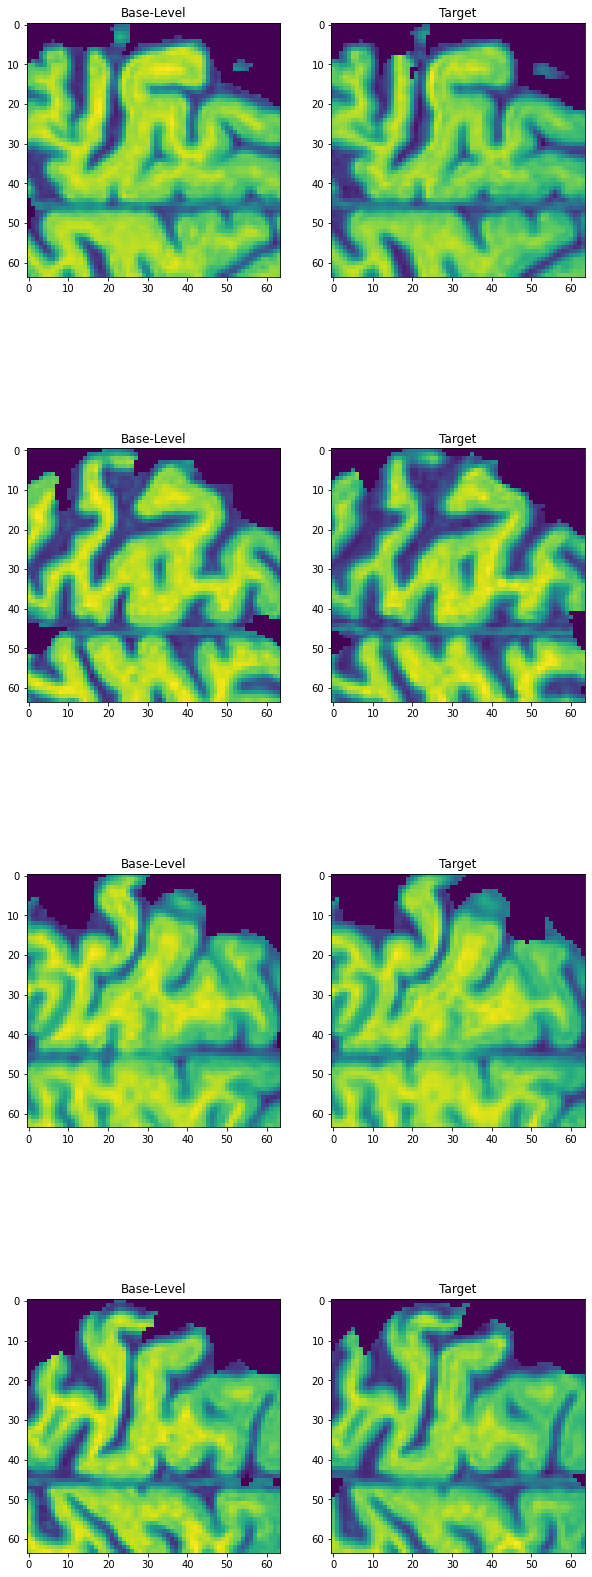

In [13]:
# Preprocess MRI images
data = DataLoader('/content/drive/MyDrive/Data/Original/*.gz', '/content/drive/MyDrive/Data/Target/*.gz')
a, b = data.preprocess()

print(len(a))
print(len(b))

print(a[0].shape)

# a = original, b = target image
dataset = data.compress(a,b)

print(len(dataset[0]))
#dataset = data.load_real_samples()

In [14]:
orig, target = dataset

for a, b in zip(orig, target):
  a = a.to(device).float()
  fake_imgs = model_gen(a.to(device)).detach().cpu()
  break
print(fake_imgs.shape)

torch.Size([80, 1, 64, 64, 64])


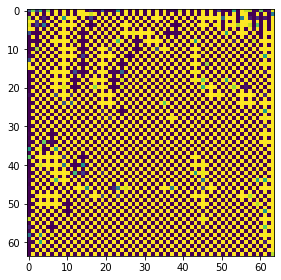

In [15]:
fake_img = fake_imgs.reshape(4,5,4,64,64,64)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)

ax1.imshow(fake_img[1,2,3,:,:,32])

# Training


In [16]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,4,4,4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [ ]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100

start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

orig, target = dataset

for epoch in range(num_epochs):
    for a,b in zip(orig,target):
      print("A shape =", a.shape)
      print("B shape =", b.shape)
      ba_si = a.size(0)

      # real image
      real_a = a.to(device).float()
      real_b = b.to(device).float()

      # patch label
      real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
      fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

      # generator
      model_gen.zero_grad()

      fake_b = model_gen(real_a) # 가짜 이미지 생성 
      
      print(np.isnan(fake_b).any()) 

      out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별
      
      
      print(np.isnan(out_dis).any()) 

      gen_loss = loss_func_gan(out_dis, real_label)
      pixel_loss = loss_func_pix(fake_b, real_b)

      g_loss = gen_loss + lambda_pixel * pixel_loss
      g_loss.backward()
      opt_gen.step()

      # discriminator
      model_dis.zero_grad()

      out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
      real_loss = loss_func_gan(out_dis,real_label)

      out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
      fake_loss = loss_func_gan(out_dis,fake_label)

      d_loss = (real_loss + fake_loss) / 2.
      d_loss.backward()
      opt_dis.step()

      loss_hist['gen'].append(g_loss.item())
      loss_hist['dis'].append(d_loss.item())

      batch_count += 1
      if batch_count % 100 == 0:
        print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

A shape = torch.Size([80, 1, 64, 64, 64])
B shape = torch.Size([80, 1, 64, 64, 64])
A shape = torch.Size([80, 1, 64, 64, 64])
B shape = torch.Size([80, 1, 64, 64, 64])
